In [1]:
import time

import tqdm
import torch
import numpy
import wandb
import random
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from sklearn.metrics import accuracy_score, roc_auc_score, top_k_accuracy_score, precision_score, recall_score, f1_score, classification_report

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 256
N_EPOCHS = 25

RANDOM_STATE = 42

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

In [2]:
# Transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = torch.tensor([ 0.491, 0.482, 0.446 ]),
        std = torch.tensor([ 0.247, 0.243, 0.261 ])
    )
])

# Load dataset
train_set = torchvision.datasets.CIFAR10('cifar-10', train = True, download = True, transform = transforms)
test_set = torchvision.datasets.CIFAR10('cifar-10', train = False, download = True, transform = transforms)

# Dataloaders
train_loader = torchdata.DataLoader(train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)
test_loader = torchdata.DataLoader(test_set, batch_size = TEST_BATCH_SIZE, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


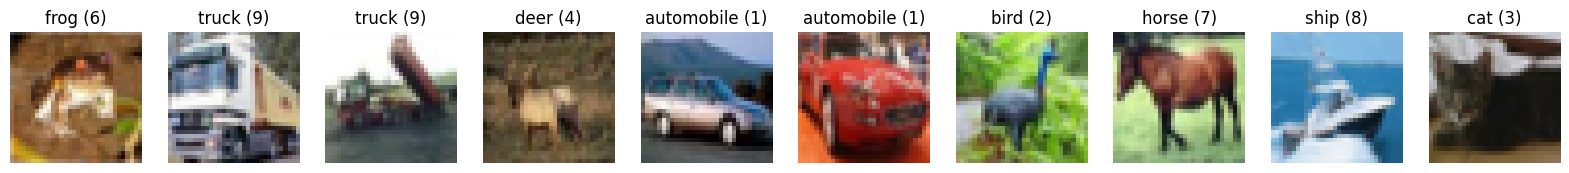

In [3]:
# Denormalization
denormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1 / transforms.transforms[1].std
    ),
    torchvision.transforms.Normalize(
        mean = -transforms.transforms[1].mean,
        std = [ 1., 1., 1. ]
    )
])

# Display some samples
plt.rcParams["figure.figsize"] = (20, 10)
for i in range(10):
    image, class_num = train_set[i]
    plt.subplot(1, 10, i + 1)
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.axis('off')
    plt.title('{} ({})'.format(train_set.classes[class_num], str(class_num)))

In [4]:
# Validation function. Don't cahnge it
def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# 1. Multi layer perceptron

Implement CIFAR10 classifier using a fully connected neural network.



In [5]:
class TwoLayerFCN(torch.nn.Module):
    def __init__(self, classes: int = 10):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(3072, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, classes)
        )

    def forward(self, x):
        return self.model(x)

### Train your model

In [6]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

In [7]:
def calc_metrics(model) -> dict:
    model.eval() # Enter evaluation mode
    model = model.to(device) # To GPU
    with torch.no_grad():
        y_predicted = numpy.array([])
        y_true = numpy.array([])
        scores = numpy.empty((0, 10))
        for images, labels in test_loader:
            # To GPU
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = torch.nn.Softmax(dim = 1)(model(images))
            predicted = torch.argmax(outputs, dim = 1)

            # Store predictions
            y_predicted = numpy.append(y_predicted, predicted.cpu().detach().numpy())
            y_true = numpy.append(y_true, labels.cpu().detach().numpy())
            scores = numpy.concatenate([ scores, outputs.cpu().detach().numpy() ])

    return {
        'Accuracy': accuracy_score(y_true, y_predicted),
        'TOP-2 Accuracy': top_k_accuracy_score(y_true, scores, k = 2),
        'TOP-3 Accuracy': top_k_accuracy_score(y_true, scores, k = 3),
        'TOP-4 Accuracy': top_k_accuracy_score(y_true, scores, k = 4),
        'TOP-5 Accuracy': top_k_accuracy_score(y_true, scores, k = 5),
        'TOP-6 Accuracy': top_k_accuracy_score(y_true, scores, k = 6),
        'TOP-7 Accuracy': top_k_accuracy_score(y_true, scores, k = 7),
        'TOP-8 Accuracy': top_k_accuracy_score(y_true, scores, k = 8),
        'TOP-9 Accuracy': top_k_accuracy_score(y_true, scores, k = 9),
        'AUC-ROC': roc_auc_score(y_true, scores, multi_class = 'ovo'),
        'Precision': precision_score(y_true, y_predicted, average = 'macro'),
        'Recall': recall_score(y_true, y_predicted, average = 'macro'),
        'F1-score': f1_score(y_true, y_predicted, average = 'macro')
    }

In [8]:
def train(
    name: str,
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer
):    
    # Start wandb
    wandb.init(project = "NIS-HW-3", name = name, anonymous = "allow", config = {
        'model': str(model),
        'criterion': str(criterion),
        'optimizer': str(optimizer)
    })
    wandb.watch(model, log = "all")
    
    # Define metrics - does not work for some reason: metrics disappear from the summary (?)
    # wandb.define_metric('Accuracy',        summary = 'best', goal = 'maximize')
    # wandb.define_metric('TOP-2 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-3 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-4 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-5 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-6 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-7 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-8 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('TOP-9 Accuracy',  summary = 'none', goal = 'maximize')
    # wandb.define_metric('AUC-ROC',         summary = 'best', goal = 'maximize')
    # wandb.define_metric('Precision',       summary = 'best', goal = 'maximize')
    # wandb.define_metric('Recall',          summary = 'best', goal = 'maximize')
    # wandb.define_metric('F1-score',        summary = 'best', goal = 'maximize')
    # wandb.define_metric('Loss',            summary = 'last', goal = 'minimize')
    # wandb.define_metric('Train time',      summary = 'mean', goal = 'minimize')
    # wandb.define_metric('Validation time', summary = 'mean', goal = 'minimize')

    best_metrics = None
    model = model.to(device) # To GPU
    for epoch in tqdm.trange(N_EPOCHS):
        model.train() # Enter train mode
        train_start = time.perf_counter()
        for images, labels in train_loader:
            # To GPU
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero gradients
            output = model(images) # Get predictions
            loss = criterion(output, labels) # Calculate loss
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights

        train_time = time.perf_counter() - train_start # Calculate train time

        val_start = time.perf_counter()
        metrics = calc_metrics(model) # Calculate metrics
        val_time = time.perf_counter() - val_start # Calculate validation time

        # Save to wandb
        metrics['Loss'] = loss.item()
        metrics['Train time'] = train_time
        metrics['Validation time'] = val_time
        wandb.log(metrics)

        if (best_metrics is None) or (metrics['Accuracy'] > best_metrics['Accuracy']):
            best_metrics = metrics

    wandb.finish() # Finish wandb run
    return best_metrics

# 2. Compare different optimizators

* Take three different optimizers e.g.: SGD, SGD with momentum, AdamW.
* Train the model with each of them.
* Plot the loss curve for different optimizers in same axis


*Because this task is time consuming it is recommended to perform calculations on a small piece of datastat*

In [9]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
train("AdamW", model, criterion, optimizer)

100%|██████████| 25/25 [02:07<00:00,  5.11s/it]


AUC-ROC,▁▄▅▆▆▆▇▇█▆▇███▇██▇▆▇▆▆▆▇▆
Accuracy,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
F1-score,▁▄▄▅▅▇▇▇▇▆▅███▇▇▇▇▇█▇▆▇▇▇
Loss,██▆▇▆▅▅▅▅▄▃▄▄▃▃▃▂▂▂▂▂▁▁▂▁
Precision,▁▄▅▅▆█▇▆▇▆▅▇███▇▇▇▇█▆▇▇▇█
Recall,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
TOP-2 Accuracy,▁▄▅▆▆▆▇▇█▆▆███▇▇▇▇▆█▆▇▆▆▆
TOP-3 Accuracy,▁▅▅▆▆▆▇▇█▆▆█▇█▇▇█▇▇▇▆▇▆▆▆
TOP-4 Accuracy,▁▅▅▅▆▆▆▇▇▆▆███▇▇▇▇▇▇▆▇▆▇▆
TOP-5 Accuracy,▁▄▅▆▆▆▇▇▇▆▆█▇▇▇▇▇▇▇▇▇▇▆▇▇
TOP-6 Accuracy,▁▅▅▆▆▆▇▇▇▆▆███▇██▇▇▇▇▇▇▇▇


{'Accuracy': 0.5373,
 'TOP-2 Accuracy': 0.7252,
 'TOP-3 Accuracy': 0.8243,
 'TOP-4 Accuracy': 0.8909,
 'TOP-5 Accuracy': 0.9311,
 'TOP-6 Accuracy': 0.9582,
 'TOP-7 Accuracy': 0.9765,
 'TOP-8 Accuracy': 0.9877,
 'TOP-9 Accuracy': 0.9957,
 'AUC-ROC': 0.8923859333333334,
 'Precision': 0.5347110067425962,
 'Recall': 0.5372999999999999,
 'F1-score': 0.5341636568857993,
 'Loss': 0.8819297552108765,
 'Train time': 4.032024400003138,
 'Validation time': 0.9180000999986078}

In [10]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0)
train("SGD", model, criterion, optimizer)

100%|██████████| 25/25 [02:05<00:00,  5.02s/it]


AUC-ROC,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇█▅▇▅▇█▇▇▆▄
Accuracy,▁▃▄▄▅▅▆▅▆▆▆▇▇▇▆▇▄▇▅▇█▇▇▆▄
F1-score,▁▃▄▄▅▅▆▅▆▆▆▇▆▇▆▇▄▇▅▇█▇▇▆▃
Loss,▇▇▅▅▄▄▃▄▄▂▂▂▃▂▂▂▂▁▂▂▂▂▁▂█
Precision,▁▃▄▄▅▆▆▆▇▆▆▇▇▇▇▇▅▇▅▇█▇▇▇▅
Recall,▁▃▄▄▅▅▆▅▆▆▆▇▇▇▆▇▄▇▅▇█▇▇▆▄
TOP-2 Accuracy,▁▃▄▄▅▅▆▆▇▆▇▇▇▇▇▇▄▇▅▇█▇▇▆▄
TOP-3 Accuracy,▁▃▄▄▅▅▆▆▇▆▇▇▆▇▇█▅▇▅▇█▇▇▇▃
TOP-4 Accuracy,▁▃▄▄▅▆▆▆▇▆▇▇▆▇▇█▅▇▅▇█▇▆▇▂
TOP-5 Accuracy,▁▃▅▅▆▆▇▆▇▆▇▇▆▇▇█▅█▆▇█▇▆▇▁
TOP-6 Accuracy,▂▄▅▅▆▆▇▇▇▇▇▇▆▇▇█▆▇▆▇█▇▆▇▁


{'Accuracy': 0.5412,
 'TOP-2 Accuracy': 0.7369,
 'TOP-3 Accuracy': 0.8326,
 'TOP-4 Accuracy': 0.8958,
 'TOP-5 Accuracy': 0.9335,
 'TOP-6 Accuracy': 0.9615,
 'TOP-7 Accuracy': 0.9774,
 'TOP-8 Accuracy': 0.9889,
 'TOP-9 Accuracy': 0.9962,
 'AUC-ROC': 0.8975963999999998,
 'Precision': 0.5427353154269806,
 'Recall': 0.5412,
 'F1-score': 0.5406843643716115,
 'Loss': 1.068582534790039,
 'Train time': 4.3765835000012885,
 'Validation time': 0.8685158000007505}

In [11]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
train("SGD with momentum", model, criterion, optimizer)

100%|██████████| 25/25 [02:05<00:00,  5.01s/it]


AUC-ROC,▁▄▅▆▇▇▇▇▇██▇██████▇▇▇▇▇▇▇
Accuracy,▁▃▅▅▆▆▇▇▇█▇▇▇█▇██▇▇▇▇▇▇▇▇
F1-score,▁▃▅▆▆▆▇▇▇█▇▇▇████▇███████
Loss,██▆▇▆▅▅▅▅▄▄▄▄▃▃▃▂▃▂▂▃▁▁▂▁
Precision,▁▃▄▅▆▆▆▆▆█▇▇▇█▇██▇███████
Recall,▁▃▅▅▆▆▇▇▇█▇▇▇█▇██▇▇▇▇▇▇▇▇
TOP-2 Accuracy,▁▃▅▆▇▇▇▇▇█▇▇██████▇▇██▇▇▇
TOP-3 Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇███▇█▇▇▇▇▇▇▇▇
TOP-4 Accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇
TOP-5 Accuracy,▁▃▅▆▆▇▆▇▇▇▇▇██▇██▇▇▇▇▇▇▇▇
TOP-6 Accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇█


{'Accuracy': 0.541,
 'TOP-2 Accuracy': 0.7315,
 'TOP-3 Accuracy': 0.8337,
 'TOP-4 Accuracy': 0.8953,
 'TOP-5 Accuracy': 0.9354,
 'TOP-6 Accuracy': 0.9589,
 'TOP-7 Accuracy': 0.9772,
 'TOP-8 Accuracy': 0.9878,
 'TOP-9 Accuracy': 0.9955,
 'AUC-ROC': 0.8969364277777779,
 'Precision': 0.5387199225675918,
 'Recall': 0.541,
 'F1-score': 0.5379764793799018,
 'Loss': 0.8000137805938721,
 'Train time': 4.233729300001869,
 'Validation time': 0.9382828999987396}

In [12]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())
train("Adagrad", model, criterion, optimizer)

100%|██████████| 25/25 [02:06<00:00,  5.07s/it]


AUC-ROC,▁▄▄▅▆▆▇▆▇▆▇▇▇█▇█▆█▇██▇▇▇▇
Accuracy,▁▃▃▄▅▆▆▅▆▅▇▇▇▇▇█▆▇▇▇█▇▇▆▇
F1-score,▁▃▃▄▅▆▅▅▆▅▆▆▇▇▇█▆▇▇▇█▇▇▆▇
Loss,█▇▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▁▁▂▂▂▁▂▁
Precision,▁▃▃▄▅▆▆▆▆▆▆▆▇▇▇█▆▇▇▇█▇▇▇▇
Recall,▁▃▃▄▅▆▆▅▆▅▇▇▇▇▇█▆▇▇▇█▇▇▆▇
TOP-2 Accuracy,▁▃▃▄▅▆▆▆▇▆▇▇▇▇▇█▆█▇▇█▇▇▆▇
TOP-3 Accuracy,▁▃▃▅▆▆▆▆▇▆▇▇▇▇▇█▆█▇███▇▆█
TOP-4 Accuracy,▁▃▃▅▆▇▇▆▇▆▇▇▇█▇█▇█▇▇██▇▆▇
TOP-5 Accuracy,▁▄▄▅▆▇▇▆▇▆▇█▇▇██▇████▇▇▇▇
TOP-6 Accuracy,▁▃▃▅▆▇▇▆▇▅▇█▇▇██▇█▇███▇▇▇


{'Accuracy': 0.5469,
 'TOP-2 Accuracy': 0.7362,
 'TOP-3 Accuracy': 0.8321,
 'TOP-4 Accuracy': 0.8947,
 'TOP-5 Accuracy': 0.9328,
 'TOP-6 Accuracy': 0.9607,
 'TOP-7 Accuracy': 0.9794,
 'TOP-8 Accuracy': 0.9887,
 'TOP-9 Accuracy': 0.9961,
 'AUC-ROC': 0.8979863777777777,
 'Precision': 0.5473042317253162,
 'Recall': 0.5468999999999999,
 'F1-score': 0.5462900410486284,
 'Loss': 0.9202567338943481,
 'Train time': 3.9080610999990313,
 'Validation time': 0.8530403000004299}

In [13]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.ASGD(model.parameters())
train("ASGD", model, criterion, optimizer)

100%|██████████| 25/25 [02:39<00:00,  6.38s/it]


AUC-ROC,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
F1-score,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
Loss,█▇▆▆▅▄▃▄▄▃▃▃▃▃▃▃▁▁▂▃▃▂▁▂▂
Precision,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
Recall,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
TOP-2 Accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
TOP-3 Accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
TOP-4 Accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████
TOP-5 Accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
TOP-6 Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███████


{'Accuracy': 0.5048,
 'TOP-2 Accuracy': 0.7018,
 'TOP-3 Accuracy': 0.8069,
 'TOP-4 Accuracy': 0.8739,
 'TOP-5 Accuracy': 0.9198,
 'TOP-6 Accuracy': 0.9506,
 'TOP-7 Accuracy': 0.9729,
 'TOP-8 Accuracy': 0.9868,
 'TOP-9 Accuracy': 0.995,
 'AUC-ROC': 0.8802573555555554,
 'Precision': 0.5011083667510156,
 'Recall': 0.5048000000000001,
 'F1-score': 0.5000469749192813,
 'Loss': 1.3891526460647583,
 'Train time': 5.330481099997996,
 'Validation time': 1.202961699997104}

In [14]:
set_random_seed(RANDOM_STATE)
model = TwoLayerFCN(10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters())
train("NAdam", model, criterion, optimizer)

100%|██████████| 25/25 [02:32<00:00,  6.10s/it]


AUC-ROC,▄▆▄▆▇▇▆▆▁▇▇▆█▇▆█▆▇█▇██▇▆▇
Accuracy,▃▅▃▂▆▆▅▄▁▆▆▆▇▆▆▇▅▇█▇██▇▆█
F1-score,▃▅▃▁▆▇▅▄▁▆▅▆▇▆▇▇▅▇████▇▇█
Loss,█▇▇▇▅▅▄▆█▄▃▅▄▄▃▂▄▃▁▃▂▁▁▄▂
Precision,▁▄▁▇▅▆▆▅▂▆▅▆█▇▆█▆▇▇█▇█▆▇▇
Recall,▃▅▃▂▆▆▅▄▁▆▆▆▇▆▆▇▅▇█▇██▇▆█
TOP-2 Accuracy,▃▆▃▃▆▆▅▅▁▇▆▆▇▆▆█▅██▇██▇▇█
TOP-3 Accuracy,▃▆▃▃▆▇▅▅▁▇▇▆█▆▆█▆█████▇▇▇
TOP-4 Accuracy,▃▆▄▄▆▇▆▆▁▇▇▇█▇▆█▆█████▇█▇
TOP-5 Accuracy,▃▆▄▅▇▇▆▆▁▇█▇█▇▇█▇█████▇██
TOP-6 Accuracy,▄▇▄▆▇▇▆▇▁▇█▇█▇▇█▇█████▇██


{'Accuracy': 0.533,
 'TOP-2 Accuracy': 0.7242,
 'TOP-3 Accuracy': 0.8277,
 'TOP-4 Accuracy': 0.89,
 'TOP-5 Accuracy': 0.9294,
 'TOP-6 Accuracy': 0.9568,
 'TOP-7 Accuracy': 0.9757,
 'TOP-8 Accuracy': 0.9879,
 'TOP-9 Accuracy': 0.9962,
 'AUC-ROC': 0.8913214333333335,
 'Precision': 0.5371414360860143,
 'Recall': 0.533,
 'F1-score': 0.5279933284505702,
 'Loss': 0.7868971228599548,
 'Train time': 6.109768099999201,
 'Validation time': 1.408822000001237}

Значительной разницы в рассмотренных алгоритмах оптимизации нет. Явно выделяется лишь ASGD, при использовании которого качество оказалось заметно хуже остальных. Другие рассмотренные оптимизаторы получили примерно одинаковое качество около 54%. Далее будем использовать AdamW, так как он достиг качества, близкого к максимальному, за наименьшее количество эпох, а также наиболее хорошо минимазировал значение лосс-функции. (TODO: график)

# Ideas for extra work

* Find optimal size of hidden layer ✅
* Plot mean absolute gradients value per layer ✅
* Compare different Activation functions ✅
* Use instruments like [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html) or [WandB](https://wandb.ai/site) to log results ✅
* Use [Lightning](https://lightning.ai/) to implement train loop

## Different Loss Functions

In [15]:
def test_loss_function(criterion, name):
    set_random_seed(RANDOM_STATE)
    model = TwoLayerFCN(10).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    train(name, model, criterion, optimizer)

In [16]:
test_loss_function(torch.nn.CrossEntropyLoss(), "CrossEntropyLoss")

100%|██████████| 25/25 [02:34<00:00,  6.19s/it]


AUC-ROC,▁▄▅▆▆▆▇▇█▆▇███▇██▇▆▇▆▆▆▇▆
Accuracy,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
F1-score,▁▄▄▅▅▇▇▇▇▆▅███▇▇▇▇▇█▇▆▇▇▇
Loss,██▆▇▆▅▅▅▅▄▃▄▄▃▃▃▂▂▂▂▂▁▁▂▁
Precision,▁▄▅▅▆█▇▆▇▆▅▇███▇▇▇▇█▆▇▇▇█
Recall,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
TOP-2 Accuracy,▁▄▅▆▆▆▇▇█▆▆███▇▇▇▇▆█▆▇▆▆▆
TOP-3 Accuracy,▁▅▅▆▆▆▇▇█▆▆█▇█▇▇█▇▇▇▆▇▆▆▆
TOP-4 Accuracy,▁▅▅▅▆▆▆▇▇▆▆███▇▇▇▇▇▇▆▇▆▇▆
TOP-5 Accuracy,▁▄▅▆▆▆▇▇▇▆▆█▇▇▇▇▇▇▇▇▇▇▆▇▇
TOP-6 Accuracy,▁▅▅▆▆▆▇▇▇▆▆███▇██▇▇▇▇▇▇▇▇


In [17]:
loss = torch.nn.MultiLabelMarginLoss()
def MultiLabelMarginLoss(output, labels):
    nul = torch.full((output.shape[0], 1), -1).to(device)
    labels = torch.cat([ labels.unsqueeze(1), nul, nul, nul, nul, nul, nul, nul, nul, nul ], dim = 1)
    return loss(output, labels)

test_loss_function(MultiLabelMarginLoss, "MultiLabelMarginLoss")

100%|██████████| 25/25 [02:37<00:00,  6.30s/it]


AUC-ROC,▁▅▅▆▇▆▇▆█▇▇▇██▇▇██▇██▇▇█▇
Accuracy,▁▄▄▅▅▆▇▅▆▆▇▆▇▇▆▇▇▇▇██▇▆█▆
F1-score,▁▄▄▅▅▆▇▅▇▆▇▆▇▇▇▇▇▇▇█▇▇▇█▇
Loss,██▅▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Precision,▁▄▄▅▅▆▇▅▇▇▆▆█▇▇▇▇▇▇█▇███▇
Recall,▁▄▄▅▅▆▇▅▆▆▇▆▇▇▆▇▇▇▇██▇▆█▆
TOP-2 Accuracy,▁▄▅▆▆▆▇▅▇▇▆▇██▇▇▇▇▇▇█▆▇█▆
TOP-3 Accuracy,▁▅▅▆▆▇▇▅▇▇▇▇██▇▇█▇▇▇▇▆▆█▆
TOP-4 Accuracy,▁▄▅▅▆▆▇▄▇█▆▇█▇▇▇█▆▇▇▇▆▆▇▇
TOP-5 Accuracy,▁▄▅▅▆▆▇▅▇▇▆▇█▇▇▇█▆▇▇▇▆▆▆▆
TOP-6 Accuracy,▁▄▅▆█▇▇▅▇▇▇▇▇██▇█▇█▇▇▇▇▇▇


In [18]:
softmax = torch.nn.LogSoftmax(dim = 1)
loss = torch.nn.NLLLoss()
def NLLLoss(output, labels):
    output = softmax(output)
    return loss(output, labels)

test_loss_function(NLLLoss, "NLLLoss")

100%|██████████| 25/25 [02:35<00:00,  6.22s/it]


AUC-ROC,▁▄▅▆▆▆▇▇█▆▇███▇██▇▆▇▆▆▆▇▆
Accuracy,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
F1-score,▁▄▄▅▅▇▇▇▇▆▅███▇▇▇▇▇█▇▆▇▇▇
Loss,██▆▇▆▅▅▅▅▄▃▄▄▃▃▃▂▂▂▂▂▁▁▂▁
Precision,▁▄▅▅▆█▇▆▇▆▅▇███▇▇▇▇█▆▇▇▇█
Recall,▁▄▄▅▅▇▇▇▇▆▅▇██▇▇▇▇▆▇▇▆▇▇▆
TOP-2 Accuracy,▁▄▅▆▆▆▇▇█▆▆███▇▇▇▇▆█▆▇▆▆▆
TOP-3 Accuracy,▁▅▅▆▆▆▇▇█▆▆█▇█▇▇█▇▇▇▆▇▆▆▆
TOP-4 Accuracy,▁▅▅▅▆▆▆▇▇▆▆███▇▇▇▇▇▇▆▇▆▇▆
TOP-5 Accuracy,▁▄▅▆▆▆▇▇▇▆▆█▇▇▇▇▇▇▇▇▇▇▆▇▇
TOP-6 Accuracy,▁▅▅▆▆▆▇▇▇▆▆███▇██▇▇▇▇▇▇▇▇


Изменение лосс-функции также не дало значительного повышения качества. Заметим, что поведение NLLoss полностью совпадает с CrossEntropyLoss. Действительно, CrossEntropyLoss является ничем иным, как последовательным применением `LogSoftmax` и `CrossEntropyLoss`. Для дальнейшего анализа будем использовать CrossEntropyLoss, который показал себя чуть лучше MultiLabelMarginLoss

## Different net architecture

### Batch normalization
На графиках видно, что градиент `bias` последнего слоя выглядит достаточно странно: явно смещён от нуля. В такой ситуации должно помочь добавление нормализации в скрытый слой.

In [19]:
def test_net_arch(model, name):
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())
    train(name, model, criterion, optimizer)

In [20]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 500),
    torch.nn.BatchNorm1d(500), # Added
    torch.nn.ReLU(),
    torch.nn.Linear(500, 10)
)
test_net_arch(model, "BatchNorm")

100%|██████████| 25/25 [02:22<00:00,  5.69s/it]


AUC-ROC,▁▄▅▆▇▇▇▇██▇▇██████▇▇███▇▇
Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇████▇▇▇▇▇██▇
F1-score,▁▃▅▅▅▆▇▇▇▇▇▇▇██▇█▇▇██▇██▇
Loss,██▆▇▆▅▄▅▅▄▃▄▄▃▃▂▂▂▂▂▂▁▁▁▁
Precision,▁▃▅▅▆▆▆▆▇▇▇▇█████▇██████▇
Recall,▁▃▅▅▆▆▇▇▇▇▇▇▇████▇▇▇▇▇██▇
TOP-2 Accuracy,▁▃▅▆▇▇▇▇▇▇▇▇███▇██▆▇▇▇▇▇▇
TOP-3 Accuracy,▁▃▅▅▆▆▇▇█▇▇▆▇█████▇▇██▇▇▇
TOP-4 Accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇██▇█▇▇▇█▇▇▇▇
TOP-5 Accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇██▇▇█
TOP-6 Accuracy,▁▄▅▆▇▇▇▇██▇▇▇█████▇▇▇█▇▇▇


Добавление нормализации действительно помогло: качество немного увеличилось, а градиенты выглядят лучше

### Different activation functions


In [21]:
def test_activation_function(module, name):
    set_random_seed(RANDOM_STATE)
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(3072, 500),
        torch.nn.BatchNorm1d(500),
        module,
        torch.nn.Linear(500, 10)
    )
    return test_net_arch(model, name)

In [22]:
test_activation_function(torch.nn.ReLU(), "ReLU")

100%|██████████| 25/25 [02:33<00:00,  6.16s/it]


AUC-ROC,▁▄▅▆▇▇▇▇██▇▇██████▇▇███▇▇
Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇████▇▇▇▇▇██▇
F1-score,▁▃▅▅▅▆▇▇▇▇▇▇▇██▇█▇▇██▇██▇
Loss,██▆▇▆▅▄▅▅▄▃▄▄▃▃▂▂▂▂▂▂▁▁▁▁
Precision,▁▃▅▅▆▆▆▆▇▇▇▇█████▇██████▇
Recall,▁▃▅▅▆▆▇▇▇▇▇▇▇████▇▇▇▇▇██▇
TOP-2 Accuracy,▁▃▅▆▇▇▇▇▇▇▇▇███▇██▆▇▇▇▇▇▇
TOP-3 Accuracy,▁▃▅▅▆▆▇▇█▇▇▆▇█████▇▇██▇▇▇
TOP-4 Accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇██▇█▇▇▇█▇▇▇▇
TOP-5 Accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇██▇▇█
TOP-6 Accuracy,▁▄▅▆▇▇▇▇██▇▇▇█████▇▇▇█▇▇▇


In [23]:
test_activation_function(torch.nn.ELU(), "ELU")

100%|██████████| 25/25 [02:17<00:00,  5.50s/it]


AUC-ROC,▁▃▄▅▆▆▆▆▇▇▇▆▇█▇███▇▇▇████
Accuracy,▁▂▄▅▅▆▆▆▆▇▇▆▇▇▇▇██▇▇▇▇███
F1-score,▁▂▄▅▅▆▆▆▆▇▇▆▇▇▇▇████▇████
Loss,██▆▇▅▅▄▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Precision,▁▂▄▅▅▆▆▆▆▇▇▆▇▇▇██████████
Recall,▁▂▄▅▅▆▆▆▆▇▇▆▇▇▇▇██▇▇▇▇███
TOP-2 Accuracy,▁▃▄▅▆▆▆▆▇▇▇▆▇▇▇▇██▇▇█████
TOP-3 Accuracy,▁▂▄▄▆▆▆▆▇▆▆▆▇▇▇▇█▇▇▇▇▇█▇█
TOP-4 Accuracy,▁▂▄▄▅▆▆▆▇▆▇▇▇▇▇███▇████▇█
TOP-5 Accuracy,▁▂▄▅▅▆▆▆▆▆▇▆▇▇▇▇██▇█▇███▇
TOP-6 Accuracy,▁▃▄▅▆▆▆▆▆▇▇▇█▇▇███▇▇█▇██▇


In [24]:
test_activation_function(torch.nn.LeakyReLU(), "LeakyReLU")

100%|██████████| 25/25 [02:02<00:00,  4.92s/it]


AUC-ROC,▁▃▅▆▇▇▇▇███▇██████▇▇███▇█
Accuracy,▁▃▅▅▆▇▇▇▇▇▇▇▇█████▇██▇███
F1-score,▁▃▅▅▆▇▆▇▇▇▇▇▇█████▇██▇███
Loss,██▆▇▆▅▄▅▅▄▃▄▄▃▃▂▃▂▂▂▂▁▁▁▁
Precision,▁▃▅▅▆▆▆▆▇▇▆▇▇████▇▇██▇███
Recall,▁▃▅▅▆▇▇▇▇▇▇▇▇█████▇██▇███
TOP-2 Accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇██▇██▆▇█▇██▇
TOP-3 Accuracy,▁▃▅▅▆▆▆▆▇▇▇▆▇██▇▇▇▇▇▇▇▇▇▇
TOP-4 Accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇█▇▇█▇▇▇█▇▇▇█
TOP-5 Accuracy,▁▄▅▅▆▇▆▆█▇▇▇▇▇▇▇██▇▇█▇█▇█
TOP-6 Accuracy,▁▄▄▅▆▇▆▆▇▇▇▇▆▇▆▇▇▇▆▇▇▇▇▇█


In [25]:
test_activation_function(torch.nn.PReLU(), "PReLU")

100%|██████████| 25/25 [02:04<00:00,  4.96s/it]


AUC-ROC,▁▃▅▆▇▇████████▇██▇▇▇▇▇▇▇▇
Accuracy,▁▃▅▆▆▇▇▇▇███▇█▇███▇▇▇▇▇▇▇
F1-score,▁▃▅▆▆▇▇▇▇███▇█▇███▇▇█▇▇▇▇
Loss,██▇▇▆▅▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁
Precision,▁▃▅▆▆▇▇█▇█████▇██████▇▇▇▇
Recall,▁▃▅▆▆▇▇▇▇███▇█▇███▇▇▇▇▇▇▇
TOP-2 Accuracy,▁▃▅▆▇▇████████▇█▇▇▇▇▇▇▇▇▇
TOP-3 Accuracy,▁▃▅▆▇▇█▇███▇██▇█▇█▇▇▇▇▇▇▇
TOP-4 Accuracy,▁▃▅▆▇▇█▇▇▇█▇▇█▇███▇▇▇▇▇▇▇
TOP-5 Accuracy,▁▄▆▆▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇
TOP-6 Accuracy,▁▄▆▆▇▇█▇▇▇██▇██████▇▇▇▇█▇


In [26]:
test_activation_function(torch.nn.RReLU(), "RReLU")

100%|██████████| 25/25 [02:04<00:00,  4.97s/it]


AUC-ROC,▁▃▅▅▆▆▆▆▇▇▇▇▇█▇████▇▇██▇█
Accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇████
F1-score,▁▂▄▅▅▆▆▆▆▇▇▇▇█▇█▇█▇▇█████
Loss,██▆▇▆▅▄▅▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Precision,▁▂▄▅▅▆▆▆▇▇▇▇▇█▇██████████
Recall,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇████
TOP-2 Accuracy,▁▃▄▅▆▆▆▆▇▇▆▆▇▇▇▇██▇▇▇██▇█
TOP-3 Accuracy,▁▂▄▄▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█
TOP-4 Accuracy,▁▂▄▄▆▆▆▆▇▆▇▆▇██▇██▇▇███▇█
TOP-5 Accuracy,▁▃▅▅▆▆▆▆▇▇▇▇█▇█▇███▇███▇█
TOP-6 Accuracy,▁▃▄▅▆▆▆▇▇▆▇▇▇▇▇▇▇██▇███▇█


In [27]:
test_activation_function(torch.nn.SELU(), "SELU")

100%|██████████| 25/25 [02:01<00:00,  4.88s/it]


AUC-ROC,▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇█▇▇█▇█████
Accuracy,▁▃▄▄▄▅▅▆▆▇▇▇▇▇▇█▇██▇▇████
F1-score,▁▂▄▄▄▅▅▆▆▇▆▇▇▇▇█▇▇███████
Loss,██▆▇▆▅▄▅▅▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁
Precision,▁▂▄▄▄▅▅▆▆▆▇▇▇▇▇█▇████████
Recall,▁▃▄▄▄▅▅▆▆▇▇▇▇▇▇█▇██▇▇████
TOP-2 Accuracy,▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
TOP-3 Accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███▇█
TOP-4 Accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇█▇███████
TOP-5 Accuracy,▁▂▄▄▄▅▅▆▆▆▆▆▇▇▇▇█▇██▇▇██▇
TOP-6 Accuracy,▁▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇


In [28]:
test_activation_function(torch.nn.GELU(), "GELU")

100%|██████████| 25/25 [02:01<00:00,  4.85s/it]


AUC-ROC,▁▄▆▆▇▇▇███▇▇██████▆▇▇▇▇▇▇
Accuracy,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▆▇▇▇▇▇▇
F1-score,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▇▇▇▇▇▇▇
Loss,██▆▇▆▅▅▅▅▄▄▄▄▄▄▂▃▂▂▂▂▁▁▁▁
Precision,▁▃▅▅▆▆▆▇▇▇▆▆▇█▇▇▇▇▇▇▇▇▇▇▇
Recall,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▆▇▇▇▇▇▇
TOP-2 Accuracy,▁▃▆▆▇▇▇█▇▇▇▇▇█████▆▇█▇▇▇▇
TOP-3 Accuracy,▁▃▅▅▇▇▇▇▇▇▇▇▇█████▆██▇▇▇▇
TOP-4 Accuracy,▁▄▅▅▇▇▇▇▇▇▇▇██████▇██▇█▇█
TOP-5 Accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▇██▇██▇▇█▇▇▇▇
TOP-6 Accuracy,▁▄▅▆▇▇▇▇▇██▇▇█▇█▇█▇██▇▇▇█


In [29]:
test_activation_function(torch.nn.Sigmoid(), "Sigmoid")

100%|██████████| 25/25 [02:08<00:00,  5.12s/it]


AUC-ROC,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇███
Accuracy,▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
F1-score,▁▂▂▂▂▃▃▃▂▄▄▄▅▅▅▅▅▆▆▇▇▇███
Loss,▇█▆▇▇▆▅▅▆▄▃▄▄▄▄▃▂▂▂▂▂▂▁▁▁
Precision,▁▂▂▂▃▃▄▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
Recall,▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇███
TOP-2 Accuracy,▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇███
TOP-3 Accuracy,▁▁▁▂▂▂▃▃▃▄▄▃▄▅▅▅▆▅▆▆▇▇██▇
TOP-4 Accuracy,▁▂▂▂▃▂▃▃▂▄▄▄▄▅▅▆▅▆▆▆▇▇███
TOP-5 Accuracy,▁▂▂▂▃▂▃▃▂▃▄▄▄▅▅▅▅▆▇▆▇▇██▇
TOP-6 Accuracy,▁▂▂▂▃▂▃▂▃▃▄▄▄▄▅▆▆▆▇▇█████


Явно видно, что сигмоида, ожидаемо, показывает себя заметно хуже остальные, а SELU - немного хуже. Далее будем использовать GELU, так как модель с именно этой функцией активации достигла наибольшего качества

### Different hidden layer size

In [30]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 500),
    torch.nn.BatchNorm1d(500),
    torch.nn.GELU(),
    torch.nn.Linear(500, 10)
)
test_net_arch(model, "500 hidden neurons")

100%|██████████| 25/25 [02:40<00:00,  6.41s/it]


AUC-ROC,▁▄▆▆▇▇▇███▇▇██████▆▇▇▇▇▇▇
Accuracy,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▆▇▇▇▇▇▇
F1-score,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▇▇▇▇▇▇▇
Loss,██▆▇▆▅▅▅▅▄▄▄▄▄▄▂▃▂▂▂▂▁▁▁▁
Precision,▁▃▅▅▆▆▆▇▇▇▆▆▇█▇▇▇▇▇▇▇▇▇▇▇
Recall,▁▃▅▅▆▇▇▇▇▇▇▆██▇▇█▇▆▇▇▇▇▇▇
TOP-2 Accuracy,▁▃▆▆▇▇▇█▇▇▇▇▇█████▆▇█▇▇▇▇
TOP-3 Accuracy,▁▃▅▅▇▇▇▇▇▇▇▇▇█████▆██▇▇▇▇
TOP-4 Accuracy,▁▄▅▅▇▇▇▇▇▇▇▇██████▇██▇█▇█
TOP-5 Accuracy,▁▄▅▅▆▇▆▇▇▇▇▇▇██▇██▇▇█▇▇▇▇
TOP-6 Accuracy,▁▄▅▆▇▇▇▇▇██▇▇█▇█▇█▇██▇▇▇█


In [31]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 2000),
    torch.nn.BatchNorm1d(2000),
    torch.nn.GELU(),
    torch.nn.Linear(2000, 10)
)
test_net_arch(model, "2000 hidden neurons")

100%|██████████| 25/25 [02:18<00:00,  5.52s/it]


AUC-ROC,▁▄▅▆▇▇▇██████▇▇███▇▇█▇▇▇▆
Accuracy,▁▃▄▆▆▇▆▇▇▇▇██▇▇████▇███▇▇
F1-score,▁▃▄▆▆▆▆▇▇▇▇▇█▇▇████▇█▇█▇▇
Loss,█▇▇▆▆▆▆▅▅▅▄▄▃▄▄▃▂▂▂▂▁▁▂▁▁
Precision,▁▃▄▅▆▆▆▇▇▇▇▇█▇▇█▇▇█▇█▇█▇█
Recall,▁▃▄▆▆▇▆▇▇▇▇██▇▇████▇███▇▇
TOP-2 Accuracy,▁▄▅▆▇▇▇██████▇▇████▇█▇█▇▇
TOP-3 Accuracy,▁▄▄▆▇▆▇▇█▇▇▇█▇▇██▇▇▇█▇▇▇▆
TOP-4 Accuracy,▁▄▄▆▇▇▇▇█▇▇▇█▇▇▇██▇▇█▇▇▇▆
TOP-5 Accuracy,▁▄▄▆▇▇▇▇██▇██▇█████▇█▆▇▇▇
TOP-6 Accuracy,▁▄▄▆▇▆▇▆▇█▇██▇▇▇▇▇█▇█▇▇▇▇


Добавление нейронов в скрытый слой видимого влияния на качество не оказало. Тем не менее интересно, что и время обучения не увеличилось.

In [32]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 500),
    torch.nn.BatchNorm1d(500),
    torch.nn.GELU(),
    torch.nn.Linear(500, 250),
    torch.nn.BatchNorm1d(250),
    torch.nn.GELU(),
    torch.nn.Linear(250, 10)
)
test_net_arch(model, "500 + 250 hidden neurons")

100%|██████████| 25/25 [02:01<00:00,  4.87s/it]


AUC-ROC,▁▄▆▇▇▇▇▇██▇▇▇▇▇▆▆▆▆▇▆▆▅▅▆
Accuracy,▁▄▆▇▇▇▇▇██▇█▇█▇▇▇█████▇██
F1-score,▁▄▅▆▇▇▇▇████▇█▇▇▇█████▇█▇
Loss,█▇▇▆▅▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Precision,▁▄▅▇▇▇▇▇████▇█▇▇▇████▇▇▇▇
Recall,▁▄▆▇▇▇▇▇██▇█▇█▇▇▇█████▇██
TOP-2 Accuracy,▁▄▆▇▇▇▇▇██▇▇▇▇▇▇▆▇▆▇▇▇▇▆▇
TOP-3 Accuracy,▁▄▆▆▆▇▇███▆▇▇▇▇▇▆▇▆▇▇▆▆▆▆
TOP-4 Accuracy,▁▄▆▇▇▇▇███▆▇▇▆▇▆▆▇▇▆▆▆▆▆▆
TOP-5 Accuracy,▁▄▆▇▇█▇▇▇█▆▇▇▇▆▆▆▇▇▇▆▅▆▆▆
TOP-6 Accuracy,▁▃▆▇▇▇▇▇██▆▇▇▆▆▇▆▆▆▆▇▄▆▅▅


Добавление слоёв в сеть немного увеличило качество. Попробуем добавить ещё слои, чтобы достичь наибольшего качества

In [33]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 1500),
    torch.nn.BatchNorm1d(1500),
    torch.nn.GELU(),
    torch.nn.Linear(1500, 500),
    torch.nn.BatchNorm1d(500),
    torch.nn.GELU(),
    torch.nn.Linear(500, 250),
    torch.nn.BatchNorm1d(250),
    torch.nn.GELU(),
    torch.nn.Linear(250, 10)
)
test_net_arch(model, "1500 + 500 + 250 hidden neurons")

100%|██████████| 25/25 [02:08<00:00,  5.12s/it]


AUC-ROC,▁▅▆▆▇███▇▇█▇▇▇▆▆▇▇▇▇▇▆▇▇▇
Accuracy,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█
F1-score,▁▄▄▅▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇██
Loss,█▇█▇▇▆▆▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Precision,▁▄▄▅▆▇▆▇▇▆▇▇▇▇▇▇█▇█▇█▇▇██
Recall,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█
TOP-2 Accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
TOP-3 Accuracy,▁▅▆▆▆▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█
TOP-4 Accuracy,▁▅▆▆▇▇█▇▇▆█▇▇▇▆▇▇▇▇▇▇▆▆▇▇
TOP-5 Accuracy,▁▄▆▆▇██▇▇▇█▇█▇▆▇▇▇▇▇▇▇▇▇█
TOP-6 Accuracy,▁▅▆▆▇▇▇█▇▆██▇█▇▇▇▆▇▇█▆▇▇█


In [34]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 1500),
    torch.nn.BatchNorm1d(1500),
    torch.nn.GELU(),
    torch.nn.Linear(1500, 800),
    torch.nn.BatchNorm1d(800),
    torch.nn.GELU(),
    torch.nn.Linear(800, 500),
    torch.nn.BatchNorm1d(500),
    torch.nn.GELU(),
    torch.nn.Linear(500, 250),
    torch.nn.BatchNorm1d(250),
    torch.nn.GELU(),
    torch.nn.Linear(250, 10)
)
test_net_arch(model, "1500 + 800 + 500 + 250 hidden neurons")

100%|██████████| 25/25 [02:08<00:00,  5.15s/it]


AUC-ROC,▁▄▆▆▇█████▇▇▇▇▇▇▆▆▆▆▆▆▆▇▆
Accuracy,▁▃▅▆▇▇▇▇█▇▇▇▇▇▇█▇▇████▇██
F1-score,▁▃▅▆▆▇▆▇█▇▇▇▇▇▇█▇▇████▇██
Loss,█▇▇▆▆▆▅▅▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁
Precision,▁▃▅▅▆▆▆▇██▆▇▇▇▇█▇▇████▇█▇
Recall,▁▃▅▆▇▇▇▇█▇▇▇▇▇▇█▇▇████▇██
TOP-2 Accuracy,▁▃▅▆▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇
TOP-3 Accuracy,▁▄▆▆▇▇▇▇██▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇
TOP-4 Accuracy,▁▄▆▇██████▇▇▇▇▇▇▇▇▇▆▆▇▆▇▇
TOP-5 Accuracy,▁▄▇▇██▇█▇▇▆▇█▆▇▇▇▇▇▆▆▇▆▇▇
TOP-6 Accuracy,▁▄▆▇█▇▇██▇▇▇▇▇▇▇▇▇▆▆▆▆▅▇▇


Добавлеие 3 слоя привело к повышению качества, но 4 слой не оказал значительного влияния. Следовательно, остановимся на 3 слоях.

# Итоговая модель

In [37]:
set_random_seed(RANDOM_STATE)
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3072, 1500),
    torch.nn.BatchNorm1d(1500),
    torch.nn.GELU(),
    torch.nn.Linear(1500, 500),
    torch.nn.BatchNorm1d(500),
    torch.nn.GELU(),
    torch.nn.Linear(500, 250),
    torch.nn.BatchNorm1d(250),
    torch.nn.GELU(),
    torch.nn.Linear(250, 10)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
train("FINAL MODEL", model, criterion, optimizer)

AUC-ROC,▁▇█
Accuracy,▁██
F1-score,▁▇█
Loss,█▁▄
Precision,▁▇█
Recall,▁██
TOP-2 Accuracy,▁██
TOP-3 Accuracy,▁▇█
TOP-4 Accuracy,▁▇█
TOP-5 Accuracy,▁▅█
TOP-6 Accuracy,▁██


100%|██████████| 25/25 [02:08<00:00,  5.15s/it]


AUC-ROC,▁▅▆▆▇███▇▇█▇▇▇▆▆▇▇▇▇▇▆▇▇▇
Accuracy,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█
F1-score,▁▄▄▅▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇██
Loss,█▇█▇▇▆▆▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Precision,▁▄▄▅▆▇▆▇▇▆▇▇▇▇▇▇█▇█▇█▇▇██
Recall,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█
TOP-2 Accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
TOP-3 Accuracy,▁▅▆▆▆▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█
TOP-4 Accuracy,▁▅▆▆▇▇█▇▇▆█▇▇▇▆▇▇▇▇▇▇▆▆▇▇
TOP-5 Accuracy,▁▄▆▆▇██▇▇▇█▇█▇▆▇▇▇▇▇▇▇▇▇█
TOP-6 Accuracy,▁▅▆▆▇▇▇█▇▆██▇█▇▇▇▆▇▇█▆▇▇█


{'Accuracy': 0.5778,
 'TOP-2 Accuracy': 0.7653,
 'TOP-3 Accuracy': 0.855,
 'TOP-4 Accuracy': 0.9088,
 'TOP-5 Accuracy': 0.9444,
 'TOP-6 Accuracy': 0.9667,
 'TOP-7 Accuracy': 0.9804,
 'TOP-8 Accuracy': 0.9889,
 'TOP-9 Accuracy': 0.9956,
 'AUC-ROC': 0.9052327722222222,
 'Precision': 0.5792738481730544,
 'Recall': 0.5778,
 'F1-score': 0.5780906920276,
 'Loss': 0.07882624119520187,
 'Train time': 4.166128600001684,
 'Validation time': 1.0411612000025343}

In [38]:
print('Accuracy: {}%'.format(validate(model.to('cpu'), test_loader) * 100))

model.eval()
with torch.no_grad():
    y_predicted = numpy.array([])
    y_true = numpy.array([])
    scores = numpy.empty((0, 10))
    for images, labels in test_loader:
        outputs = torch.nn.Softmax(dim = 1)(model(images))
        predicted = torch.argmax(outputs, dim = 1)

        y_predicted = numpy.append(y_predicted, predicted.cpu().detach().numpy())
        y_true = numpy.append(y_true, labels.cpu().detach().numpy())
        scores = numpy.concatenate([ scores, outputs.cpu().detach().numpy() ])

    print('TOP-1 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 1)))
    print('TOP-2 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 2)))
    print('TOP-3 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 3)))
    print('TOP-4 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 4)))
    print('TOP-5 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 5)))
    print('TOP-6 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 6)))
    print('TOP-7 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 7)))
    print('TOP-8 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 8)))
    print('TOP-9 Accuracy: {}'.format(top_k_accuracy_score(y_true, scores, k = 9)))
    print('AUC-ROC: {}'.format(roc_auc_score(y_true, scores, multi_class = 'ovo')))
    print(classification_report(y_true, y_predicted, target_names = test_set.classes, digits = 3))

Accuracy: 57.78%
TOP-1 Accuracy: 0.5778
TOP-2 Accuracy: 0.7653
TOP-3 Accuracy: 0.855
TOP-4 Accuracy: 0.9088
TOP-5 Accuracy: 0.9444
TOP-6 Accuracy: 0.9667
TOP-7 Accuracy: 0.9804
TOP-8 Accuracy: 0.9889
TOP-9 Accuracy: 0.9956
AUC-ROC: 0.9052326388888888
              precision    recall  f1-score   support

    airplane      0.638     0.649     0.643      1000
  automobile      0.706     0.666     0.685      1000
        bird      0.471     0.448     0.459      1000
         cat      0.382     0.396     0.389      1000
        deer      0.532     0.486     0.508      1000
         dog      0.461     0.508     0.483      1000
        frog      0.630     0.626     0.628      1000
       horse      0.655     0.622     0.638      1000
        ship      0.697     0.712     0.704      1000
       truck      0.622     0.665     0.643      1000

    accuracy                          0.578     10000
   macro avg      0.579     0.578     0.578     10000
weighted avg      0.579     0.578     0.578  

Модель достаточно простая: обучение происходит относительно быстро, учитывая большой размер тренировочной выборки, а применение - очень лёгкая операция. Тем не менее качество модели невелико (точность лишь немного превышает 41%). Следовательно, реализованная модель не очень хорошо подходит для классификации картинок, так как не учитывает связность пикселей, а рассматривает картинку лишь как набор независимых признаков. \
Выбор лосс-функции сильно влияет на результат: логистическая функция потерь (Cross Entropy Loss) показала значительно более высокое качество, чем SVM Loss (40% против 30%), а обучение модели с использованием логистической функции потерь произошло заметно быстрее. \
Применение L2-регуляризации заметно влияет на модель, которая оптимизирует SVM Loss. Тем не менее значительного повышения качества при использовании логистической функции потерь мне добиться не удалось.